In [ ]:
%tensorflow_version 1.x
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


# This is a colab notebook. Execute the code step by step 

# This note book contains step by step instuction on how to use MASK RCNN model for your project. 

# We are using a pretrained model which can classify below classes

class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [ ]:
# Root directory of the project
ROOT_DIR = os.path.abspath("")

In [ ]:
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

In [ ]:
!pip install mrcnn
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.config import Config

     |████████████████████████████████| 61kB 1.3MB/s 
  Created wheel for mrcnn: filename=mrcnn-0.2-cp36-none-any.whl size=54932 sha256=1a24d04a87ba05613a2dbbccf68d9b752a7c389a5b9c32fef6e8a894f67fefe8
  Stored in directory: /root/.cache/pip/wheels/11/ed/28/e550ddc897c04c336b923eae4eb35c9aae993d20ce39d9cc40
Successfully built mrcnn


Using TensorFlow backend.


In [ ]:
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
# import coco
# from pycocotools.coco import COCO
# import coco
# from demo import coco
import demo as coco

In [ ]:
%matplotlib inline 

In [ ]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [ ]:
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [ ]:
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [ ]:
# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the CocoConfig class in coco.py.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the CocoConfig class and override the attributes you need to change.

In [ ]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTA

# Create Model and Load Trained Weights

In [ ]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [ ]:
# os.mkdir("samples/coco") 
# os.mkdir("logs")
# os.mkdir("images")
os.mkdir("video")

Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our Dataset class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our Dataset class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the class_names property like this.

# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [ ]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

Run Object Detection

Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32



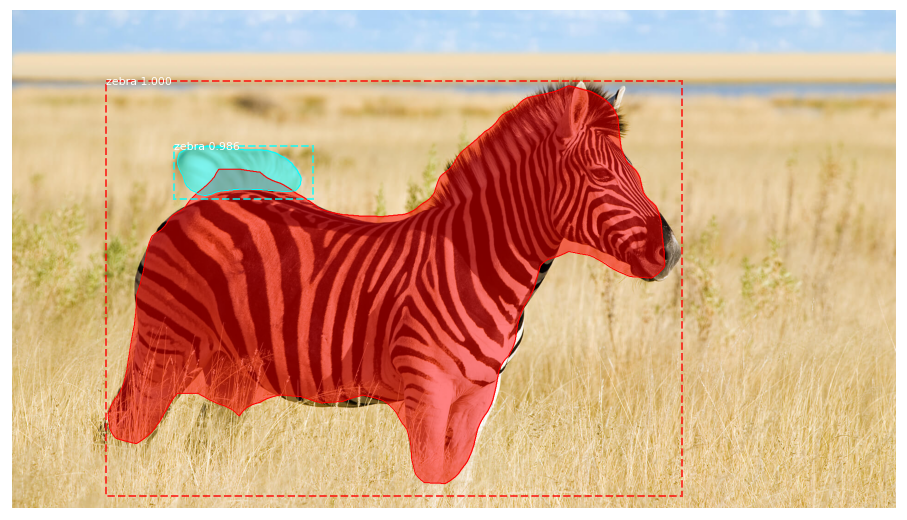

In [ ]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [ ]:
import cv2
import time

importing custom visualize

In [ ]:
import visualizeCustom7 as vc
# from PIL import Image

Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  243.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  123.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Abhishek
<class 'numpy.ndarray'>


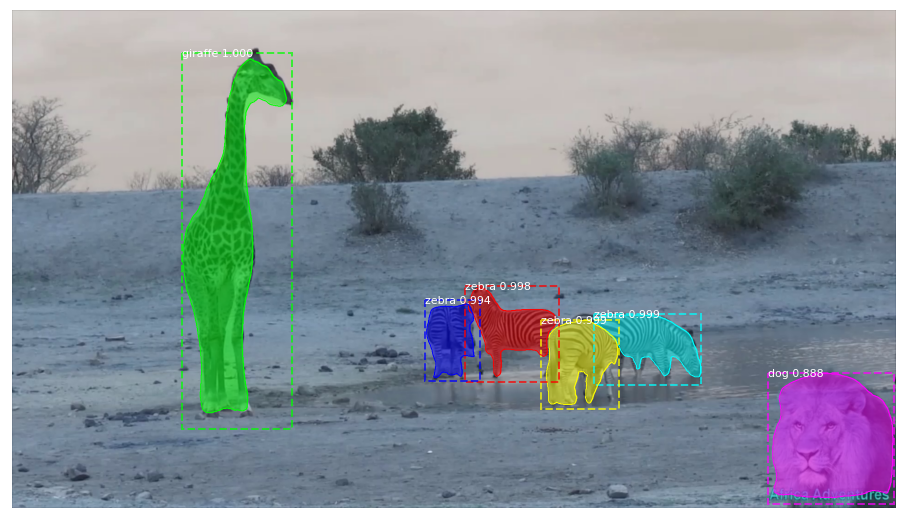

Inference time: 1.52s
here, <class 'numpy.ndarray'>
(1152, 1152, 3)
count: 1
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  243.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  123.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Abhishek
<class 'numpy.ndarray'>


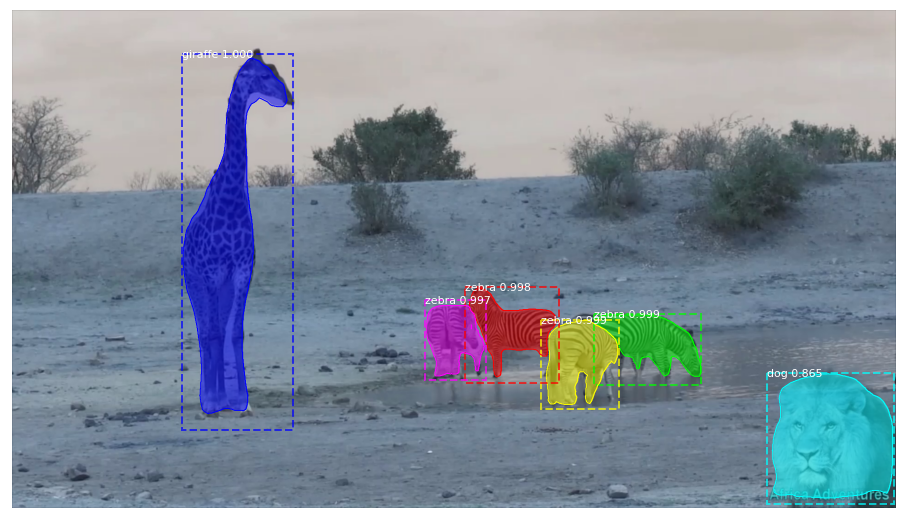

Inference time: 1.54s
here, <class 'numpy.ndarray'>
(1152, 1152, 3)
count: 2
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  243.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  123.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Abhishek
<class 'numpy.ndarray'>


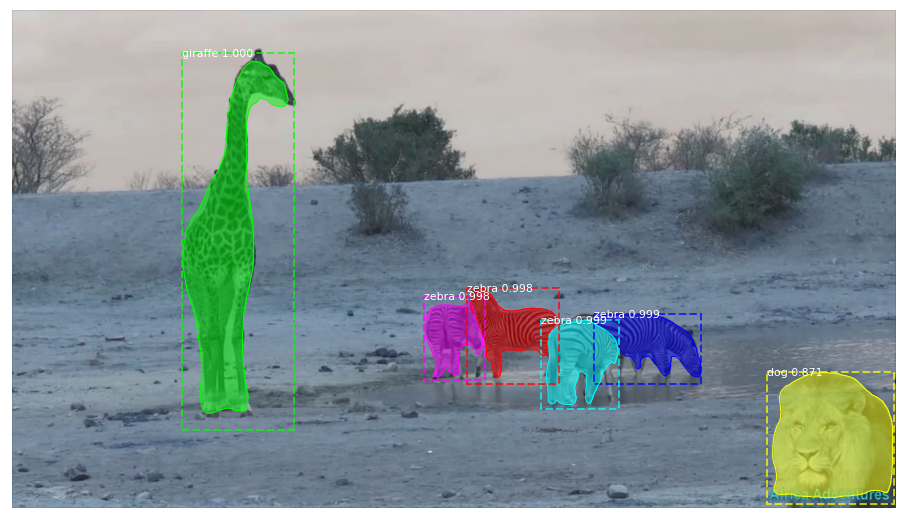

Inference time: 1.54s
here, <class 'numpy.ndarray'>
(1152, 1152, 3)
count: 3
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  243.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  123.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Abhishek
<class 'numpy.ndarray'>


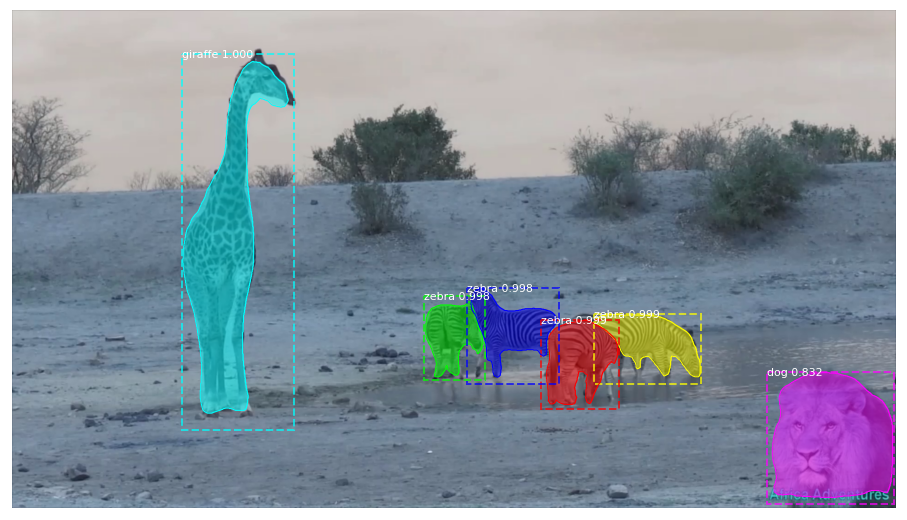

Inference time: 1.53s
here, <class 'numpy.ndarray'>
(1152, 1152, 3)
count: 4
Processing 1 images
image                    shape: (1080, 1920, 3)       min:    0.00000  max:  244.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  126.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


KeyboardInterrupt: ignored

In [ ]:
capture = cv2.VideoCapture("video/test-video-zoo.mp4")
width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH) + 0.5)
height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT) + 0.5)
size = (height, width)
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
# output_movie = cv2.VideoWriter('Zoo-video-masked.avi', fourcc, 30.0, (1920,1080))
video = cv2.VideoWriter("Zoo_video_masked.avi", cv2.VideoWriter_fourcc(*'DIVX'), fps, (1152, 1152))
# Constructing code of the codec to be used in the function VideoWriter
# writer = cv2.VideoWriter('Zoo-video-masked.mp4', fourcc, 20, (1920, 1080))
count=0
while True:
    # Capture frame-by-frame
    ret, frame = capture.read()
    if not ret:
        break

    results = model.detect([frame], verbose=1)
    r = results[0]

    boxes = r['rois']
    masks = r['masks']
    class_ids = r['class_ids']
    scores = r['scores']

    # Run detection
    start = time.time()
    masked_image = vc.display_instances(frame, boxes, masks, class_ids, class_names, scores)
    end = time.time()
    print("Inference time: {:.2f}s".format(end - start))

    # Display the resulting frame
    # cv2.imshow('', masked_image)
    #save image
    # writer = cv2.VideoWriter('Zoo-video-masked.mp4', fourcc, 30, (frame.shape[1], frame.shape[0]), True)
    #we are saving the image as "Masked-image.jpg under visualizeCustom code"
    #this image file we are writing inour videowriter object
    print("here,",type(masked_image))
    img=cv2.imread("Masked-image.jpg")
    print(img.shape)
    video.write(img)
    # output_movie.write(masked_image)
    count+=1
    print("count:",count)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

# When everything done, release the capture
print("WARNING")
cv2.destroyAllWindows()
capture.release()
video.release()
# cv2.destroyAllWindows()

In [ ]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])
print(type(test-img))

SyntaxError: ignored

# Below code is for video inferencing. WE are taking one frame at a time from input video, generating predictions and Mask, saving the picture and 
# then adding that picture to our video writer. Same process will continue for all the frames in input image

In [1]:
import cv2
capture = cv2.VideoCapture("video/test-video-zoo.mp4")
# cap = cv2.VideoCapture("your_mp4.mp4")
# ret,img=cap.read()
frame1=cv2.imread("Masked-image.jpg")
frame2=cv2.imread("Masked-image.jpg")
height , width , layers =  frame1.shape
fps=40
video = cv2.VideoWriter("zoo_out.avi", cv2.VideoWriter_fourcc(*'DIVX'), fps, (height, width))

count=0
while True:
    # Capture frame-by-frame
    ret, frame = capture.read()
    if not ret:
        break

    results = model.detect([frame], verbose=1)
    r = results[0]

    boxes = r['rois']
    masks = r['masks']
    class_ids = r['class_ids']
    scores = r['scores']

    # Run detection
    start = time.time()
    masked_image = vc.display_instances(frame, boxes, masks, class_ids, class_names, scores)
    end = time.time()
    print("Inference time: {:.2f}s".format(end - start))    
    #we are saving the image as "Masked-image.jpg under visualizeCustom code"
    #this image file we are writing inour videowriter object
    # print("here,",type(masked_image))
    img=cv2.imread("Masked-image.jpg")
    # print(img.shape)
    video.write(img)
    # output_movie.write(masked_image)
    count+=1
    print("count:",count)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

#stick your images here
# for i in range(0,20):
#     video.write(frame1)
#     video.write(frame2)
cv2.destroyAllWindows()
video.release()